# Project to use Detectron2 with custom dataset

##Installing dependencies and Detectron

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1] 
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 9.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=05090743324c1036134678f4bf0ab89cccb8abb963cd71adfbfb9520115ad45d
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 5.0 MB/s 
     |████████████████████████████████| 145 kB 8.9 MB/s 
     |████████████████████████████████| 49 kB 7.4 MB/s 
     |████████████████████████████████| 130 kB 64.3 MB/s 
     |████████████████████████████████| 74 kB 4.4 MB/s 
     |████████████████████████████████| 843 kB 68.0 MB/s 
     |████████████████████████████████

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

#Instance Segmentation

In [2]:
# Getting the dataset
!unzip cars_train.zip
!unzip cars_test.zip

Archive:  cars_train.zip
   creating: train/
  inflating: train/istockphoto-1307086567-170667a.jpg  
  inflating: train/photo-1494976388531-d1058494cdd8.jpeg  
  inflating: train/photo-1503376780353-7e6692767b70.jpeg  
  inflating: train/photo-1525609004556-c46c7d6cf023.jpeg  
  inflating: train/photo-1583121274602-3e2820c69888.jpeg  
  inflating: train/photo-1514316454349-750a7fd3da3a.jpeg  
  inflating: train/photo-1553440569-bcc63803a83d.jpeg  
  inflating: train/photo-1552519507-da3b142c6e3d.jpeg  
  inflating: train/photo-1555353540-64580b51c258.jpeg  
  inflating: train/photo-1605559424843-9e4c228bf1c2.jpeg  
  inflating: train/photo-1513036191774-b2badb8fcb76.jpeg  
  inflating: train/photo-1610399214658-52b9fdea4627.jpeg  
  inflating: train/photo-1542362567-b07e54358753.jpeg  
  inflating: train/photo-1494905998402-395d579af36f.jpeg  
  inflating: train/photo-1616422285623-13ff0162193c.jpeg  
  inflating: train/photo-1522932467653-e48f79727abf.jpeg  
  inflating: train/photo-1

In [3]:
# Saving the data
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/cars_train_annotation.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/cars_test_annotation.json", "/content/test")

[02/17 14:50:33 d2.data.datasets.coco]: Loaded 35 images in COCO format from /content/train/cars_train_annotation.json


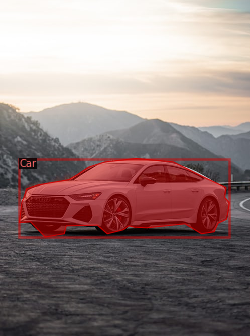

In [4]:
# Visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")
import random
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
# Create the config for the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # only one class (Car)

In [8]:
# Start training
from detectron2.engine import DefaultTrainer

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/17 14:51:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 87.7MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[02/17 14:51:15 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/17 14:51:25 d2.utils.events]:  eta: 0:08:05  iter: 19  total_loss: 1.23  loss_cls: 0.3304  loss_box_reg: 0.164  loss_mask: 0.5778  loss_rpn_cls: 0.003406  loss_rpn_loc: 0.004531  time: 0.5018  data_time: 0.0198  lr: 0.00039962  max_mem: 2599M
[02/17 14:51:35 d2.utils.events]:  eta: 0:07:52  iter: 39  total_loss: 0.4495  loss_cls: 0.09929  loss_box_reg: 0.151  loss_mask: 0.1689  loss_rpn_cls: 0.0008803  loss_rpn_loc: 0.005203  time: 0.4937  data_time: 0.0079  lr: 0.00079922  max_mem: 2659M
[02/17 14:51:46 d2.utils.events]:  eta: 0:07:45  iter: 59  total_loss: 0.2868  loss_cls: 0.04382  loss_box_reg: 0.1426  loss_mask: 0.09567  loss_rpn_cls: 0.002296  loss_rpn_loc: 0.005127  time: 0.5025  data_time: 0.0107  lr: 0.0011988  max_mem: 2704M
[02/17 14:51:56 d2.utils.events]:  eta: 0:07:44  iter: 79  total_loss: 0.1903  loss_cls: 0.02957  loss_box_reg: 0.07319  loss_mask: 0.08457  loss_rpn_cls: 0.000422  loss_rpn_loc: 0.005106  time: 0.5070  data_time: 0.0088  lr: 0.0015984  max_mem: 2704M

In [9]:
# Predicting
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/17 15:00:18 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/test/cars_test_annotation.json


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


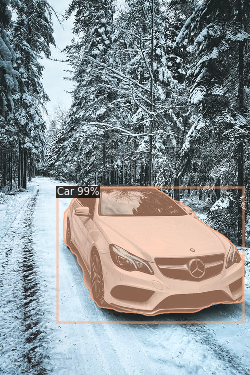

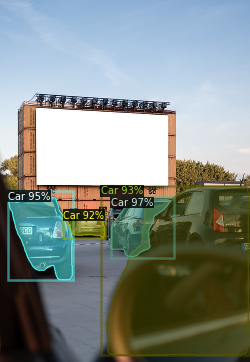

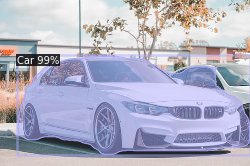

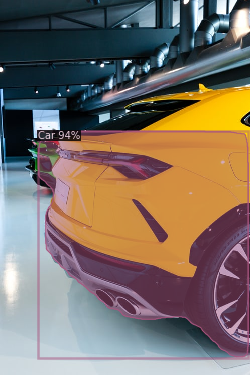

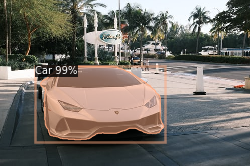

In [10]:
my_dataset_test_metadata = MetadataCatalog.get("my_dataset_train")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("my_dataset_test")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_test_metadata, 
                   scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])